In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

model_name = "gpt2"
print(f"Loading {model_name}...")
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

vocab_size = tokenizer.vocab_size
if hasattr(model.config, 'hidden_size'):
    true_dim = model.config.hidden_size
    print(f"True hidden dimension: {true_dim}")

max_queries = 2048
print(f"\nGenerating {max_queries} unique random prompts...")

random_prompts = set()
while len(random_prompts) < max_queries:
    num_tokens = 1
    token_ids = random.sample(range(vocab_size), num_tokens)
    prompt = tokenizer.decode(token_ids, skip_special_tokens=True).strip()
    if prompt:
        random_prompts.add(prompt)

random_prompts = list(random_prompts)
print(f"Generated {len(random_prompts)} unique prompts")


print("\nCollecting logits from model...")
all_logits = []
all_hidden_states = []
for i, prompt in enumerate(random_prompts):
    if i % 100 == 0:
        print(f"  Query {i}/{len(random_prompts)}")
    
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        final_hidden_state = outputs.hidden_states[-1][0, -1, :].numpy()
        all_hidden_states.append(final_hidden_state)
        # Extract last token logits
        logits = outputs.logits[0, -1, :].numpy()
        all_logits.append(logits)

full_matrix = np.array(all_logits)
print(f"Full logits collected. Shape: {full_matrix.shape}")

Loading gpt2...
True hidden dimension: 768

Generating 2048 unique random prompts...
Generated 2048 unique prompts

  Query 0/2048
  Query 100/2048
  Query 200/2048
  Query 300/2048
  Query 400/2048
  Query 500/2048
  Query 600/2048
  Query 700/2048
  Query 800/2048
  Query 900/2048
  Query 1000/2048
  Query 1100/2048
  Query 1200/2048
  Query 1300/2048
  Query 1400/2048
  Query 1500/2048
  Query 1600/2048
  Query 1700/2048
  Query 1800/2048
  Query 1900/2048
  Query 2000/2048
Full logits collected. Shape: (2048, 50257)



Running SVD and generating plots...
Subset n=512
Subset n=768
Subset n=1024
Subset n=2048

Plot saved as 'hidden_dim_attack_combined_gpt2.png'


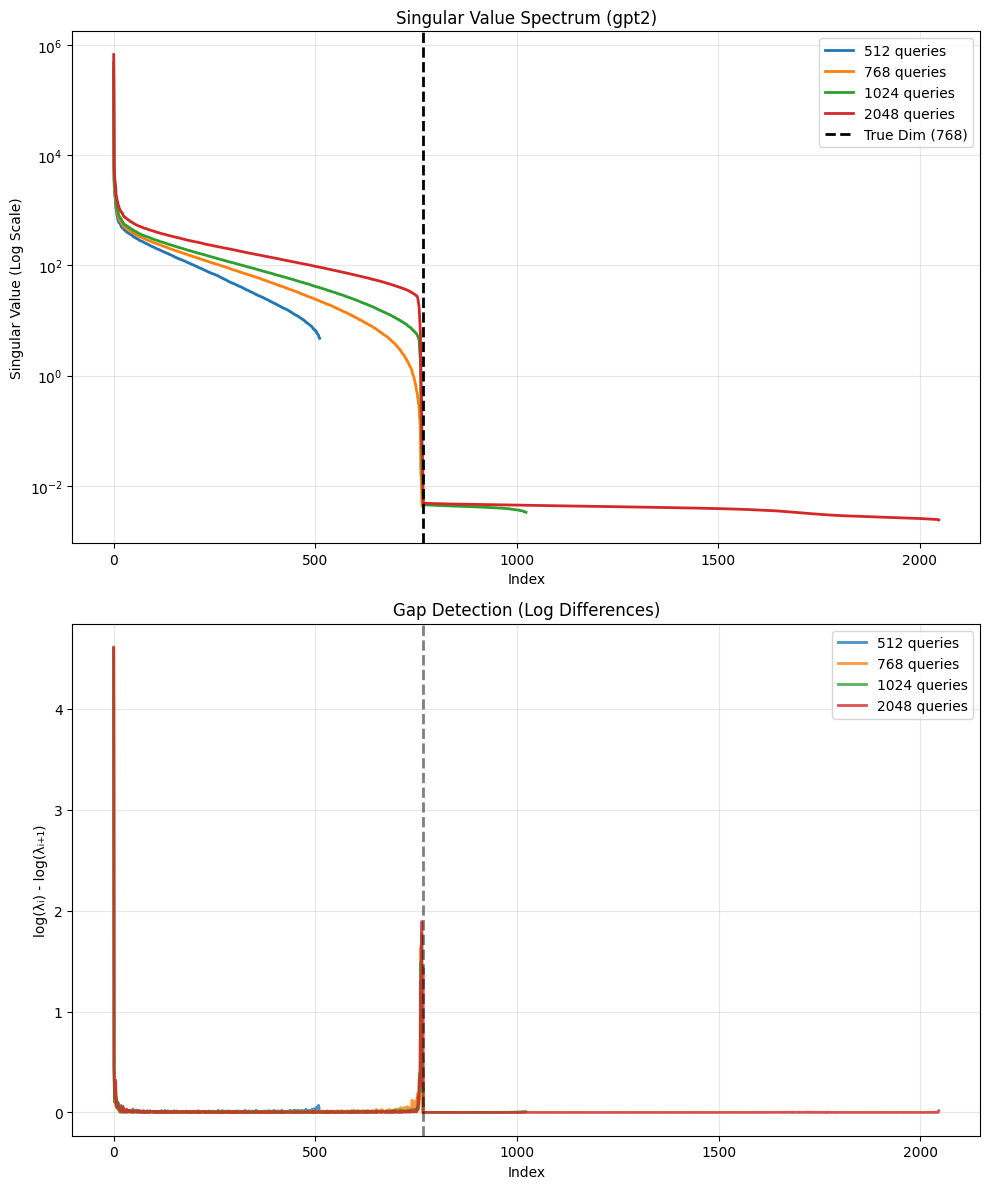

In [9]:

print("\nRunning SVD and generating plots...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
query_subsets = [512, 768, 1024, 2048]

colors = ['C0', 'C1', 'C2', 'C3']

for n, color in zip(query_subsets, colors):
    print(f"Subset n={n}")
    sub_matrix = full_matrix[:n, :]
    

    S = np.linalg.svd(sub_matrix, full_matrices=False, compute_uv=False)
    
    ax1.plot(S, linewidth=2, label=f'{n} queries', color=color)

    log_diffs = np.log(S[:-1]) - np.log(S[1:])
    
    ax2.plot(log_diffs, linewidth=2, label=f'{n} queries', color=color, alpha=0.8)
    

# -- Formatting Top Plot --
ax1.set_title(f'Singular Value Spectrum ({model_name})')
ax1.set_ylabel('Singular Value (Log Scale)')
ax1.set_xlabel('Index')
ax1.set_yscale('log')
ax1.grid(True, which="both", alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax1.axvline(x=true_dim, color='k', linestyle='--', linewidth=2, label=f'True Dim ({true_dim})')
ax1.legend()

# -- Formatting Bottom Plot --
ax2.set_title('Gap Detection (Log Differences)')
ax2.set_ylabel('log(λᵢ) - log(λᵢ₊₁)')
ax2.set_xlabel('Index')
ax2.grid(True, alpha=0.3)
# Add a line for true dimension on the bottom plot as well for reference
if hasattr(model.config, 'hidden_size'):
    ax2.axvline(x=true_dim-1, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax2.legend()

plt.tight_layout()
filename = f'hidden_dim_attack_combined_{model_name}.png'
plt.savefig(filename, dpi=300)
print(f"\nPlot saved as '{filename}'")
plt.show()

## Investigate why its not working

Hidden states shape: (2048, 768)
Number of singular values: 768
Largest singular value: 6388.56
Second Largest singular value: 652.86
Smallest singular value: 7.01e-03

Largest gap occurs at index: 0
This suggests the hidden dimension is: 1
True hidden dimension: 768


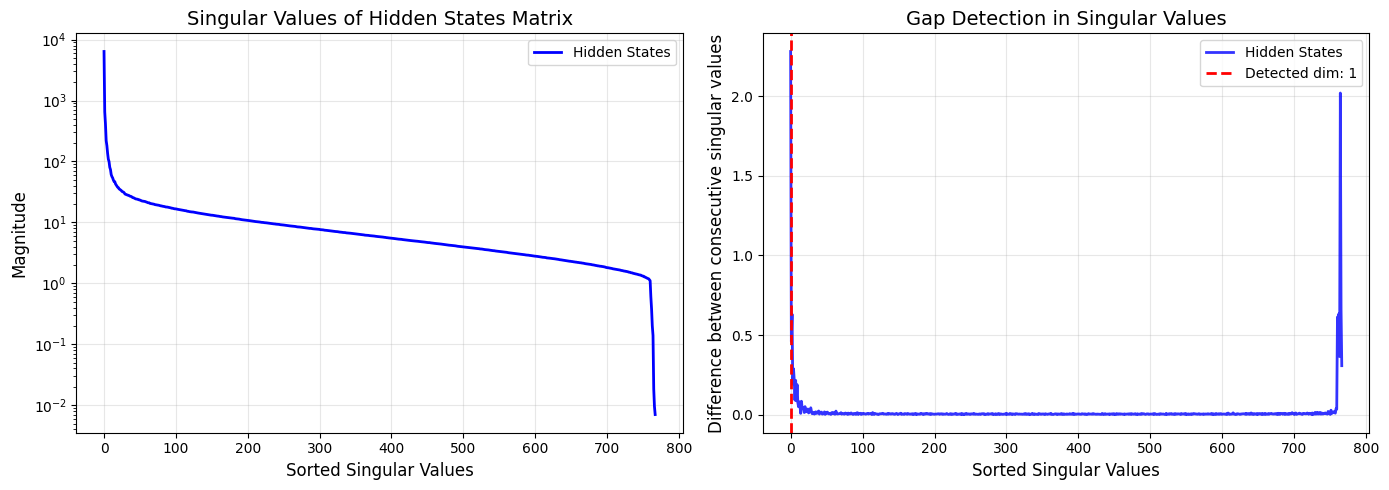


Plot saved as 'hidden_states_svd_analysis.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

full_hidden_states = np.array(all_hidden_states)
print(f"Hidden states shape: {full_hidden_states.shape}") 

S_hidden = np.linalg.svd(full_hidden_states.T, full_matrices=False, compute_uv=False)

print(f"Number of singular values: {len(S_hidden)}")
print(f"Largest singular value: {S_hidden[0]:.2f}")
print(f"Second Largest singular value: {S_hidden[1]:.2f}")
print(f"Smallest singular value: {S_hidden[-1]:.2e}")

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Singular values
ax1.plot(S_hidden, linewidth=2, color='blue', label='Hidden States')
ax1.set_xlabel('Sorted Singular Values', fontsize=12)
ax1.set_ylabel('Magnitude', fontsize=12)
ax1.set_title('Singular Values of Hidden States Matrix', fontsize=14)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Differences between consecutive singular values (to find the gap)
log_diffs_hidden = np.log(S_hidden[:-1]) - np.log(S_hidden[1:])
ax2.plot(log_diffs_hidden, linewidth=2, color='blue', alpha=0.8, label='Hidden States')
ax2.set_xlabel('Sorted Singular Values', fontsize=12)
ax2.set_ylabel('Difference between consecutive singular values', fontsize=12)
ax2.set_title('Gap Detection in Singular Values', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Find the largest gap (this should occur around the true hidden dimension)
max_gap_idx = np.argmax(log_diffs_hidden)
print(f"\nLargest gap occurs at index: {max_gap_idx}")
print(f"This suggests the hidden dimension is: {max_gap_idx + 1}")
print(f"True hidden dimension: {true_dim}")

# Add a vertical line at the detected dimension
ax2.axvline(x=max_gap_idx, color='red', linestyle='--', 
            linewidth=2, label=f'Detected dim: {max_gap_idx + 1}')
ax2.legend()

plt.tight_layout()
plt.savefig('hidden_states_svd_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'hidden_states_svd_analysis.png'")

## Full Layer Extraction

In [ ]:
print("FULL LAYER EXTRACTION ATTACK")


print("Performing full SVD to recover singular vectors...")
U, S, Vh = np.linalg.svd(full_matrix, full_matrices=False)

W_rec = Vh[:true_dim, :].T @ np.diag(S[:true_dim])
print(f"Reconstructed W shape: {W_rec.shape}")


W_true = model.lm_head.weight.detach().numpy() 
print(f"True W shape: {W_true.shape}")

print("Solving Least Squares to find transformation G...")
G, residuals, rank, s = np.linalg.lstsq(W_rec, W_true, rcond=None)

W_aligned = W_rec @ G
diff = W_aligned - W_true
mse = np.mean(diff ** 2)
rms = np.sqrt(mse)

print(f"\nOptimization Complete.")
print(f"Root Mean Square (RMS) Error: {rms:.2e}")


if rms < 1e-3:
    print("SUCCESS: Extraction is highly accurate (matches paper results).")
else:
    print("WARNING: Extraction error is higher than expected.")

In [ ]:

print("BASELINE COMPARISON: RANDOM MATRIX")
print("="*60)


W_rand = np.random.randn(*W_rec.shape)
print(f"Random W shape: {W_rand.shape}")

print("Aligning random matrix to true weights (Control Experiment)...")
G_rand, residuals_rand, rank_rand, s_rand = np.linalg.lstsq(W_rand, W_true, rcond=None)

W_rand_aligned = W_rand @ G_rand
diff_rand = W_rand_aligned - W_true
mse_rand = np.mean(diff_rand ** 2)
rms_rand = np.sqrt(mse_rand)

print(f"Random Baseline RMS Error: {rms_rand:.2e}")
print("-" * 60)


improvement = rms_rand / rms
print(f"Attack vs Random Improvement Factor: {improvement:.1f}x")
if improvement > 100:
    print("CONCLUSION: The attack successfully recovered the model weights.")
    print("            (Error is significantly lower than random baseline)")
else:
    print("CONCLUSION: The attack results are indistinguishable from noise.")
print("="*60)